In [34]:
import numpy as np
from math import pi
from scipy.linalg import block_diag
from matplotlib import pyplot
from ipywidgets import interact

In [65]:
def hopp_vec(Mx,My,vec,px,py,deform=False,R=0):
    # generates hoping matrix on square lattice
    # vec= hopping vector
    # py=1 PBC along y otherwise OBC
    # px=1 PBC along x otherwise OBC
    
    hopin=np.zeros(shape=(Mx*My,Mx*My),dtype=complex)
    for i_y in range(My):
        for i_x in range(Mx):
            i_px=i_x+vec[0]
            i_py=i_y+vec[1]
            if ((i_px>=Mx or i_px<0) and i_py< My and i_py>=0):
                if i_px>=Mx :
                    hx=px
                else:
                    hx=px.conjugate()
                i_px=i_px%Mx
                hopin[i_px+i_py*Mx,i_x+i_y*Mx]=hx
            elif ((i_py>=My or i_py<0) and i_px< Mx and i_px>=0):
                if i_py>=My :
                    hy=py
                else:
                    hy=py.conjugate()
                    
                i_py=i_py%My
                hopin[i_px+i_py*Mx,i_x+i_y*Mx]=hy
                    
            elif (i_px>=Mx or i_px<0) and (i_py>=My or i_py<0):
                if i_px>=Mx:
                    hx=px
                else:
                    hx=px.conjugate()
    
                if i_py>=My:
                    hy=py
                else:
                    hy=py.conjugate()
                i_px=i_px%Mx
                i_py=i_py%My
                hopin[i_px+i_py*Mx,i_x+i_y*Mx]=hx*hy
                
            elif i_px>=0 and i_px<Mx and i_py>=0 and i_py<My :
                if deform:
#                     if vec[0]:
#                         hopin[i_px+i_py*Mx,i_x+i_y*Mx]=np.cos(2*pi*(i_x+1/2)/Mx)
#                     elif vec[1]:
#                         hopin[i_px+i_py*Mx,i_x+i_y*Mx]=np.cos(2*pi*(i_y+1/2)/My)     
#                     else:
#                         error('This is not a hopping!')

                    hopin[i_px+i_py*Mx,i_x+i_y*Mx]=((i_y+1/2)/My-1/2)**2+((i_x+1/2)/Mx-1/2)**2-R**2
                else:
                    hopin[i_px+i_py*Mx,i_x+i_y*Mx]=1
                    
    return hopin


def vNent_contour(GA,epsilon=1e-9):
    chi0, evec0 =np.linalg.eigh(GA)
    i0=np.nonzero(np.abs(chi0)>epsilon)[0]
    chi1=chi0[i0]
    evec1=evec0[:,i0]
    i1=np.nonzero(np.abs(chi1-1)>epsilon)[0]
    chi2=chi1[i1]
    evec2=evec1[:,i1]
    DvN=-((1-chi2)*np.log(1-chi2)+chi2*np.log(chi2))
    f1=np.dot((np.abs(evec2)**2),np.diag(DvN))
    return np.sum(f1,axis=1) 


def Neg_contour(inds_A,inds_B,GA,epsilon=1e-9):
    Na=len(inds_A)
    Nb=len(inds_B)
    Nt=Na+Nb

    Gm = np.eye(Nt) - 2*GA
    Tvec = np.ones((Nt), dtype=np.complex64)
    Tvec[inds_A]=-1j*np.ones(Na)
    Tmat=np.diag(Tvec)
    Gm_1= np.dot(Tmat, np.dot(Gm,Tmat))
    Gm_2= np.dot(Tmat.conj(), np.dot(Gm,Tmat.conj()))
#     Sp=np.array([[0,1],[0,0]])
#     Gm_1=block_diag(-Gm[:Na,:Na],Gm[Na:,Na:])\
#         +np.kron(Sp,-1j*Gm[:Na,Na:])+np.kron(Sp.T,-1j*Gm[Na:,:Na])
#     Gm_2=block_diag(-Gm[:Na,:Na],Gm[Na:,Na:])\
#         +np.kron(Sp,1j*Gm[:Na,Na:])+np.kron(Sp.T,1j*Gm[Na:,:Na])    
    Gx = np.dot(np.eye(Nt)-Gm_2 , np.dot(np.linalg.inv(np.eye(Nt)+np.dot(Gm_1,Gm_2)) , np.eye(Nt)-Gm_1))/2
    Gxh = (Gx + np.transpose(Gx).conj())/2

    # contour calculation
    chi0,evec0=np.linalg.eigh(Gxh)
    i0=np.nonzero(np.abs(chi0)>epsilon)[0]
    chi1=chi0[i0]
    evec1=evec0[:,i0]
    i1=np.nonzero(np.abs(chi1-1)>epsilon)[0]
    nu=chi1[i1]
    Vx=evec1[:,i1]
    eA=np.log(nu**0.5+(1-nu)**0.5)
    PmA=np.abs(Vx)**2
    vecA=np.dot(PmA,np.diag(eA))

    chi,VR=np.linalg.eigh(GA)
    sA=np.log(chi**2+(1-chi)**2)/2
    PmR2=np.abs(VR)**2
    vecR2=np.dot(PmR2,np.diag(sA))

    cntr=np.sum(vecA,axis=1)+np.sum(vecR2,axis=1)
    return cntr

Hamiltonian is constructed
Eigenstates are found
Ent contour is computed


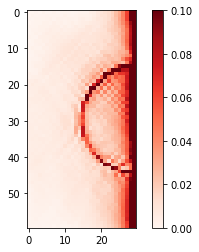

In [108]:
# static case: ground state of deformed hopping Hamiltonian
Lx=60
Ly=60
N=Lx*Ly
Lsub=int(N/2)
Npt=int(N/2) #-400
px=0
py=0

H1_hop=hopp_vec(Lx,Ly,[0,1],px,py,deform=True,R=1/4)+hopp_vec(Lx,Ly,[1,0],px,py,deform=True,R=1/4)
# H1_hop=hopp_vec(Lx,Ly,[0,1],px,py,deform=True)+hopp_vec(Lx,Ly,[1,0],px,py,deform=False)
# H1_hop=hopp_vec(Lx,Ly,[0,1],px,py)+hopp_vec(Lx,Ly,[1,0],px,py)
Amp=4
H1=Amp*(H1_hop+H1_hop.T)/2
# H1=(H1_hop+H1_hop.T)/2
print("Hamiltonian is constructed")
E1,V1=np.linalg.eigh(H1)
print("Eigenstates are found")
Gt=np.dot(V1[:,:Npt],V1[:,:Npt].T) # note: here wf is real, no conj() is needed
GA=Gt[:Lsub,:Lsub]
# GA=np.dot(V1[:Lsub,:Npt],V1[:Lsub,:Npt].T)
entcont1=vNent_contour(GA)
vN_mat=np.reshape(entcont1,[int(Ly/2),Lx])
print("Ent contour is computed")

f1=pyplot.figure()
pos=pyplot.imshow(np.real(vN_mat).T, cmap='Reds', vmin=0, vmax=0.1,
                             interpolation='none')
f1.colorbar(pos)
pyplot.show()

# LogNeg contour of whole sample
# LNcont=Neg_contour(Lsub,Lsub,Gt)
# LN_mat=np.reshape(LNcont,[Ly,Lx])
# inds_A=[]
# inds_B=[]
# for i in range(Lsub):
#     ix=i%Lx
# #     iy=int(i/Lx)
#     if ix< Lx/2 :
#         inds_A.append(i)
#     else:
#         inds_B.append(i)
# # inds_AB=np.concatenate((inds_A,inds_B))
# # Gn=Gt[np.ix_(inds_AB,inds_AB)]
# Gn=Gt[:Lsub,:Lsub]
# LNcont=Neg_contour(inds_A,inds_B,Gn)
# LN_mat=np.reshape(LNcont,[int(Ly/2),Lx])
# print("Neg contour is computed")

Neg contour of total system


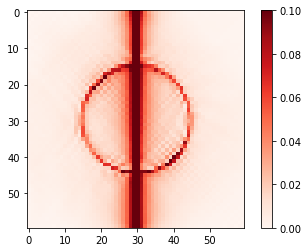

In [109]:
Gn=Gt
LNcont=Neg_contour(range(Lsub),range(Lsub,N),Gn)
LN_mat=np.reshape(LNcont,[Ly,Lx])
print("Neg contour of total system")

f2=pyplot.figure()
pos=pyplot.imshow(np.real(LN_mat).T, cmap='Reds', vmin=0, vmax=0.1,
                             interpolation='none')
f2.colorbar(pos)
pyplot.show()

Neg contour of two neighboring squares


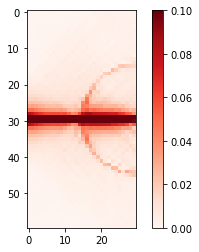

In [110]:
inds_A=[]
inds_B=[]
for i in range(Lsub):
    ix=i%Lx
#     iy=int(i/Lx)
    if ix< Lx/2 :
        inds_A.append(i)
    else:
        inds_B.append(i)
Gn=Gt[:Lsub,:Lsub]
LNcont=Neg_contour(inds_A,inds_B,Gn)
LN_mat=np.reshape(LNcont,[int(Ly/2),Lx])
print("Neg contour of two neighboring squares")

f2=pyplot.figure()
pos=pyplot.imshow(np.real(LN_mat).T, cmap='Reds', vmin=0, vmax=0.1,
                             interpolation='none')
f2.colorbar(pos)
pyplot.show()

Neg contour of two diagonal squares


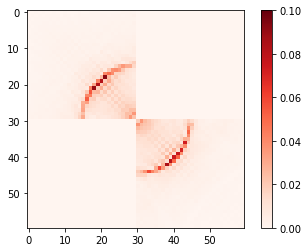

In [111]:
inds_A=[]
inds_B=[]
for i in range(N):
    ix=i%Lx
    iy=int(i/Lx)
    if ix< Lx/2 and iy< Ly/2 :
        inds_A.append(i)
    elif ix>= Lx/2 and iy>= Ly/2 :
        inds_B.append(i)

inds_AB=np.concatenate((inds_A,inds_B))
Gn=Gt[np.ix_(inds_AB,inds_AB)]
LNcont=Neg_contour(range(int(Lsub/2)),range(int(Lsub/2)),Gn)
LN_mat=np.zeros((Ly,Lx))
LN_mat[:int(Ly/2),:int(Lx/2)]= np.reshape(LNcont[:int(Lsub/2)],[int(Ly/2),int(Lx/2)])
LN_mat[int(Ly/2):,int(Lx/2):]= np.reshape(LNcont[int(Lsub/2):],[int(Ly/2),int(Lx/2)])
# LN_mat=np.reshape(LNcont,[Ly,int(Lx/2)])
print("Neg contour of two diagonal squares")

f2=pyplot.figure()
pos=pyplot.imshow(np.real(LN_mat).T, cmap='Reds', vmin=0, vmax=0.1,
                             interpolation='none')
f2.colorbar(pos)
pyplot.show()

In [113]:
# Dyanmic case: quench from uniform to deformed model
Lx=60
Ly=60
N=Lx*Ly
Lsub=int(N/2)
Npt=int(N/2)#-400
px=0
py=0

H1_hop=hopp_vec(Lx,Ly,[0,1],px,py,deform=True,R=1/4)+hopp_vec(Lx,Ly,[1,0],px,py,deform=True,R=1/4)
Amp=8
H1=Amp*(H1_hop+H1_hop.T)/2
# H1=(H1_hop+H1_hop.T)/2
E1,V1=np.linalg.eigh(H1)
print("Eigenstates of deformed Hamiltonian are computed")

H0_hop=hopp_vec(Lx,Ly,[0,1],px,py,deform=False)+hopp_vec(Lx,Ly,[1,0],px,py,deform=False)
H0=(H0_hop+H0_hop.T)/2
E0,V0=np.linalg.eigh(H0)
print("Eigenstates of uniform Hamiltonian are computed")

V_i=np.copy(V0[:,:Npt])
G_0=np.dot(V1.T,np.dot(np.dot(V_i,V_i.T),V1))

Eigenstates of deformed Hamiltonian are computed
Eigenstates of uniform Hamiltonian are computed


In [115]:
# data visualization
def plot_EE_contour(t_time=0):
    Emat=np.dot(V1,np.diag(np.exp(1j*E1*t_time)))
    Gmat=np.dot(Emat,np.dot(G_0,np.transpose(Emat).conj()))
    Lsub=int(N/2)
    GA=Gmat[:Lsub,:Lsub] 
    EE_cont=vNent_contour(GA)
    vN_mat=np.reshape(EE_cont,[int(Ly/2),Lx])

    f1=pyplot.figure()
    pos=pyplot.imshow(np.real(vN_mat).T, cmap='Reds', vmax=0.7*EE_cont.max(),
                                 interpolation='none')
    pyplot.ylabel("x")
    pyplot.xlabel("y")
    pyplot.title("t="+str(t_time))
    f1.colorbar(pos)
    pyplot.show()
    

#     LN_cont=Neg_contour(Lsub,Lsub,Gmat)
#     LN_mat=np.reshape(LN_cont,[Ly,Lx])

    inds_A=[]
    inds_B=[]
    for i in range(N):
        ix=i%Lx
        iy=int(i/Lx)
        if ix< Lx/2 and iy< Ly/2 :
            inds_A.append(i)
        elif ix>= Lx/2 and iy>= Ly/2 :
            inds_B.append(i)

    inds_AB=np.concatenate((inds_A,inds_B))
    Gn=Gmat[np.ix_(inds_AB,inds_AB)]
    LNcont=Neg_contour(range(int(Lsub/2)),range(int(Lsub/2)),Gn)
    LN_mat=np.zeros((Ly,Lx))
    LN_mat[:int(Ly/2),:int(Lx/2)]= np.reshape(LNcont[:int(Lsub/2)],[int(Ly/2),int(Lx/2)])
    LN_mat[int(Ly/2):,int(Lx/2):]= np.reshape(LNcont[int(Lsub/2):],[int(Ly/2),int(Lx/2)])

    f2=pyplot.figure()
    pos=pyplot.imshow(np.real(LN_mat).T, cmap='Reds', vmax=0.7*LN_mat.max(),
                                 interpolation='none')
    pyplot.ylabel("x")
    pyplot.xlabel("y")
    pyplot.title("t="+str(t_time))
    f1.colorbar(pos)
    pyplot.show()

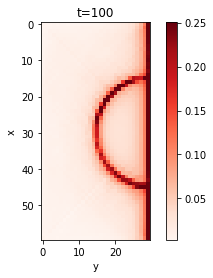

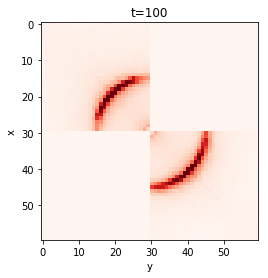

In [116]:
# single instance
plot_EE_contour(t_time=100)

In [117]:
interact(plot_EE_contour, t_time=(0, 100, 5));

interactive(children=(IntSlider(value=0, description='t_time', step=5), Output()), _dom_classes=('widget-inter…